# This is the Coursera capstone project (Seattle collisions)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
dfOriginal = pd.read_csv('Data-Collisions.csv')

C:\Users\carniato\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create train and test dataset

In [4]:
df=dfOriginal.copy()
y = df['SEVERITYCODE']
X = df.drop(['SEVERITYCODE'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Data cleaning

Inspect data first

In [5]:
def computeDetails(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
    details = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)
    details.columns = cols
    
    return details

def GetIndexses(df,col_missing_data,missingValue):
    if not missingValue :
        # nan
        indexses = df[col_missing_data].isnull()
    else:
        # comparables
        indexses = df[col_missing_data]==missingValue
        
    return indexses

def InputMissingData(df, col_missing_data, col_ref, missingValue = None):
    #group by nan or missing value
    invalid_idxs = GetIndexses(df, col_missing_data, missingValue)
    df_notval = df[invalid_idxs]
    df_notval = df_notval.groupby(col_ref).sum()  
    #print(df_notval[col_ref])
    #the valid entries
    df_val = df[~invalid_idxs]
    
    #now check the values of the reference column
    for r in df_notval.index.values:
        if isinstance(r, str):
            #a string (e.g. a location)
            df_loc = df_val[df_val[col_ref]==r]
        elif len(r)==2:
            #two doubles
            df_loc = df_val[(df_val[col_ref[0]]==r[0]) & (df_val[col_ref[1]]==r[1])]
        
        if len(df_loc) > 0:
            val = df_loc[col_missing_data].iloc[0]
            if isinstance(r, str):
                #substitute with the first valid value
                df.loc[(df[col_ref]==r) & invalid_idxs,col_missing_data]=val
            elif len(r) ==2:
                df.loc[(df[col_ref[0]]==r[0]) &(df[col_ref[1]]==r[1]) & invalid_idxs, col_missing_data] = val
        
    return df     

def bar_chart(datafr, feature):
    severityOne = datafr[datafr['SEVERITYCODE']==1][feature].value_counts()
    #print(severityOne[0]/(severityOne[0] + severityOne[1]))
    severityTwo = datafr[datafr['SEVERITYCODE']==2][feature].value_counts()
    #print(severityTwo[0]/(severityTwo[0] + severityTwo[1]))
    df = pd.DataFrame([severityOne,severityTwo])
    df.index = ['SEVERITYCODE 1','SEVERITYCODE 2']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(toLabel):
    le = LabelEncoder()
    le.fit(toLabel)
    toLabel_enc = le.transform(toLabel)
    return toLabel_enc

In [6]:
details = computeDetails(train)
print(details)

                  types  counts  distincts   nulls  missing ration
X               float64  126901      20954    3529           2.706
Y               float64  126901      21200    3529           2.706
OBJECTID          int64  130430     130430       0           0.000
INCKEY            int64  130430     130430       0           0.000
COLDETKEY         int64  130430     130430       0           0.000
REPORTNO         object  130430     130428       0           0.000
STATUS           object  130430          2       0           0.000
ADDRTYPE         object  129162          4    1268           0.972
INTKEY          float64   43707       6732   86723          66.490
LOCATION         object  128674      21416    1756           1.346
EXCEPTRSNCODE    object   56823          3   73607          56.434
EXCEPTRSNDESC    object    3792          2  126638          97.093
SEVERITYCODE.1    int64  130430          2       0           0.000
SEVERITYDESC     object  130430          2       0           0

Eliminate the columns that are semantically equal or similar to the target

In [7]:
train = train.drop(['SEVERITYCODE.1'], axis=1)
train = train.drop(['SEVERITYDESC'], axis=1)

test = test.drop(['SEVERITYCODE.1'], axis=1)
test = test.drop(['SEVERITYDESC'], axis=1)

Eliminate EXCEPTRSNDESC, not enough information

In [8]:
train['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    3792
Name: EXCEPTRSNDESC, dtype: int64

In [9]:
train = train.drop(['EXCEPTRSNDESC'], axis=1)
test = test.drop(['EXCEPTRSNDESC'], axis=1)

EXCEPTRSNCODE has no descriptive field 

In [10]:
train = train.drop(['EXCEPTRSNCODE'], axis=1)
test = test.drop(['EXCEPTRSNCODE'], axis=1)

Eliminate columns that cannot be used as prediction for an collisions

In [11]:
admin_columns = ['REPORTNO', 'COLLISIONTYPE','ST_COLCODE','ST_COLDESC','SDOT_COLCODE','SDOTCOLNUM','SDOT_COLDESC',
              'OBJECTID','INCKEY','COLDETKEY','STATUS','COLLISIONTYPE','INTKEY']

train = train.drop(admin_columns,axis=1)
test = test.drop(admin_columns,axis=1)

INATTENTIONIND id contain only yes, suppose the other equal to n

In [12]:
train['INATTENTIONIND'].value_counts()

Y    20033
Name: INATTENTIONIND, dtype: int64

In [13]:
train['INATTENTIONIND'] = train['INATTENTIONIND'].replace(np.nan,0)
train['INATTENTIONIND'] = train['INATTENTIONIND'].replace('Y',1)
train['INATTENTIONIND'].value_counts()

test['INATTENTIONIND'] = test['INATTENTIONIND'].replace(np.nan,0)
test['INATTENTIONIND'] = test['INATTENTIONIND'].replace('Y',1)

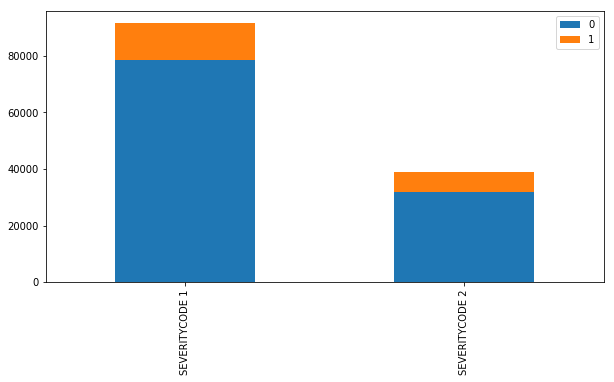

In [14]:
bar_chart(train, 'INATTENTIONIND')

In [15]:
train['PEDROWNOTGRNT'].value_counts()

Y    3163
Name: PEDROWNOTGRNT, dtype: int64

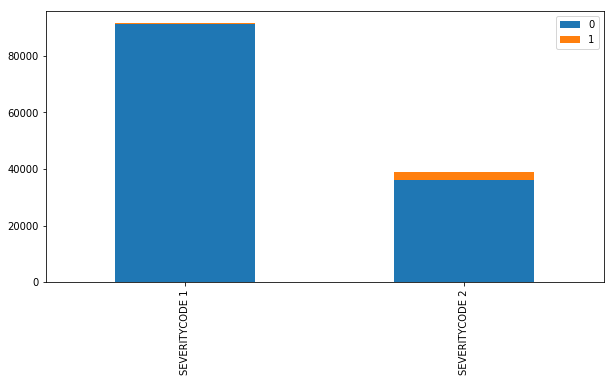

In [16]:
train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace(np.nan,0)
test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace(np.nan,0)

train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace('Y',1)
test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace('Y',1)
bar_chart(train, 'PEDROWNOTGRNT')

In [17]:
train['SPEEDING'].value_counts()

Y    6271
Name: SPEEDING, dtype: int64

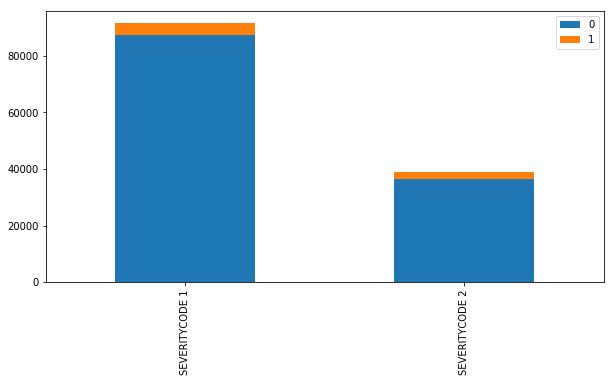

In [18]:
train['SPEEDING'] = train['SPEEDING'].replace(np.nan,0)
test['SPEEDING'] = test['SPEEDING'].replace(np.nan,0)

train['SPEEDING'] = train['SPEEDING'].replace('Y',1)
test['SPEEDING'] = test['SPEEDING'].replace('Y',1)
bar_chart(train, 'SPEEDING')

In [19]:
train['UNDERINFL'].value_counts()
train['UNDERINFL'] = train['UNDERINFL'].replace('N',0)
train['UNDERINFL'] = train['UNDERINFL'].replace('Y',1)  
train['UNDERINFL'] = train['UNDERINFL'].replace('0',0) 
train['UNDERINFL'] = train['UNDERINFL'].replace('1',1) 
train['UNDERINFL'].value_counts()

test['UNDERINFL'] = test['UNDERINFL'].replace('N',0)
test['UNDERINFL'] = test['UNDERINFL'].replace('Y',1)  
test['UNDERINFL'] = test['UNDERINFL'].replace('0',0) 
test['UNDERINFL'] = test['UNDERINFL'].replace('1',1) 

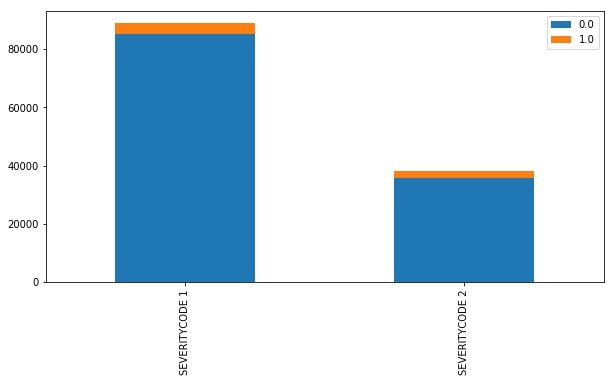

In [20]:
bar_chart(train, 'UNDERINFL')

we could try to fill the missing 'JUNCTIONTYPE' by looking X,Y

In [21]:
original_length = len(train)
train = InputMissingData(train, 'JUNCTIONTYPE', ['X','Y'])
test = InputMissingData(test, 'JUNCTIONTYPE', ['X','Y'])
dropped_len = len(train.dropna())
print("percentage dropped ", (original_length-dropped_len)/original_length)

percentage dropped  0.056122057808786326


# Treat the dates

In [22]:
train['INCDTTM'] = pd.to_datetime(train['INCDTTM'])
test['INCDTTM'] = pd.to_datetime(test['INCDTTM'])

In [23]:
train = train.drop(['INCDATE'], axis=1)
test = test.drop(['INCDATE'], axis=1)

check incidents by hour

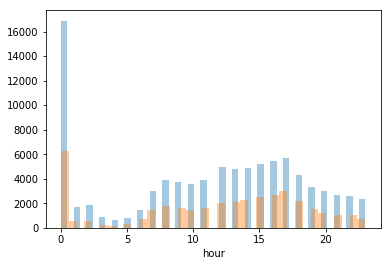

In [24]:
train['hour'] = train['INCDTTM'].dt.hour
test['hour'] = test['INCDTTM'].dt.hour

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['hour'],kde = False)

df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['hour'],kde = False)

Check day of the week

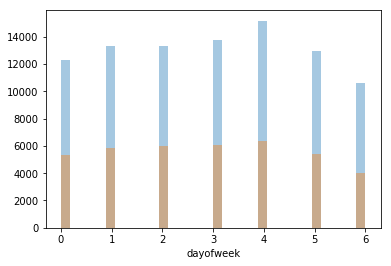

In [25]:
train['dayofweek'] = train['INCDTTM'].dt.dayofweek
test['dayofweek'] = test['INCDTTM'].dt.dayofweek

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['dayofweek'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['dayofweek'],kde = False)

Check month

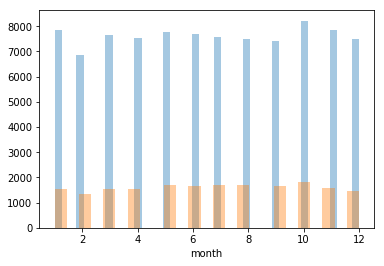

In [26]:
train['month'] = train['INCDTTM'].dt.month
test['month'] = test['INCDTTM'].dt.month

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['month'],kde = False)
df_selected = test[test['SEVERITYCODE']==2]
sns.distplot(df_selected['month'],kde = False)

In [27]:
train = train.drop(['INCDTTM'], axis=1)
test = test.drop(['INCDTTM'], axis=1)

# Check outliers

In [28]:
details = computeDetails(train)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  126901      20954   3529           2.706
Y               float64  126901      21200   3529           2.706
ADDRTYPE         object  129162          4   1268           0.972
LOCATION         object  128674      21416   1756           1.346
PERSONCOUNT       int64  130430         44      0           0.000
PEDCOUNT          int64  130430          6      0           0.000
PEDCYLCOUNT       int64  130430          3      0           0.000
VEHCOUNT          int64  130430         12      0           0.000
JUNCTIONTYPE     object  128733          8   1697           1.301
INATTENTIONIND    int64  130430          2      0           0.000
UNDERINFL       float64  127113          3   3317           2.543
WEATHER          object  126977         12   3453           2.647
ROADCOND         object  127022         10   3408           2.613
LIGHTCOND        object  126926         10   3504           2.686
PEDROWNOTG

PERSONCOUNT   0   81
2     76565
3     23735
4      9859
1      8768
5      4453
0      3732
6      1828
7       759
8       345
9       150
10       86
11       34
12       17
13       15
14       10
15        9
17        7
16        6
44        5
19        4
26        4
18        3
20        3
47        3
34        3
22        2
23        2
24        2
25        2
29        2
21        2
32        2
36        2
54        1
37        1
43        1
41        1
39        1
30        1
31        1
28        1
27        1
81        1
57        1
Name: PERSONCOUNT, dtype: int64
PEDCOUNT   0   6
0    125818
1      4442
2       150
3        15
4         4
6         1
Name: PEDCOUNT, dtype: int64
PEDCYLCOUNT   0   2
0    126705
1      3700
2        25
Name: PEDCYLCOUNT, dtype: int64
VEHCOUNT   0   11
2     98861
1     17238
3      8721
0      3455
4      1666
5       342
6        96
7        30
8        10
9         7
11        3
10        1
Name: VEHCOUNT, dtype: int64
SEGLANEKEY   0   52524

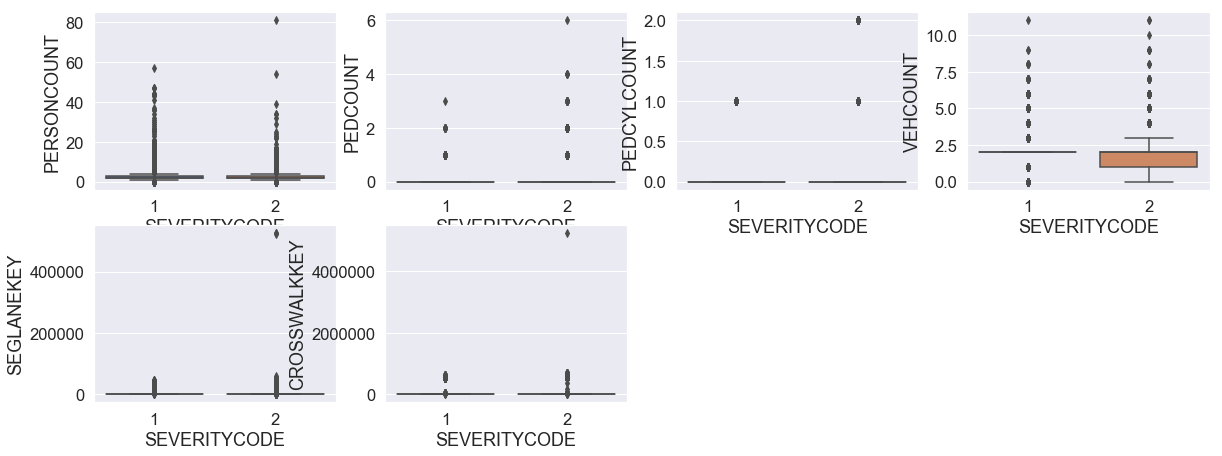

In [29]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
key='PERSONCOUNT'
fig1 = fig.add_subplot(441); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='PEDCOUNT'
fig1 = fig.add_subplot(442); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())


key='PEDCYLCOUNT'
fig1 = fig.add_subplot(443); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='VEHCOUNT'
fig1 = fig.add_subplot(444); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='SEGLANEKEY'
fig1 = fig.add_subplot(445); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='CROSSWALKKEY'
fig1 = fig.add_subplot(446); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

remove outliers

In [30]:
len_before = len(train)

train = train[train['PERSONCOUNT']<81]
train = train[train['SEGLANEKEY']<525241]
train = train[train['CROSSWALKKEY']<5239700]

test = test[test['PERSONCOUNT']<81]
test = test[test['SEGLANEKEY']<525241]
test = test[test['CROSSWALKKEY']<5239700]

len_after = len(train)
print("Num outliers removed ",len_before-len_after)

Num outliers removed  3


check distributions

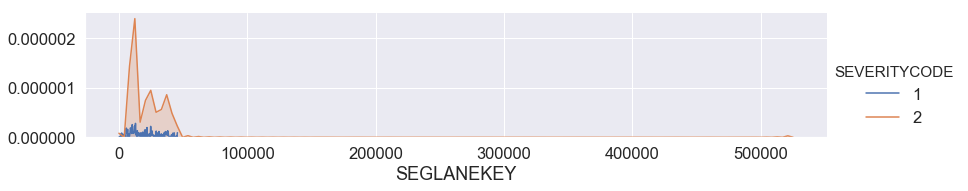

Num outliers removed  4


In [31]:
key='SEGLANEKEY'
len_before = len(train)
df_selected = train#[train[key]<50000]
facet = sns.FacetGrid(df_selected, hue="SEVERITYCODE",aspect=4)
facet.map(sns.kdeplot,key,shade= True)
facet.add_legend()
plt.show()


len_before = len(train)
train = train[train[key]<50000]
test = test[test[key]<50000]
len_after = len(train)
print("Num outliers removed ",len_before-len_after)

# Save cleaned up dataframe

In [32]:
train.dropna(inplace=True)
train.to_csv('Data-Collisions-train.csv')

test.dropna(inplace=True)
test.to_csv('Data-Collisions-test.csv')

d:\apps\python_3_7_4\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Load cleaned dataframe

In [85]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [86]:
train = pd.read_csv('Data-Collisions-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)
train.dropna(inplace=True)
details = computeDetails(train)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  123103      20536      0           0.000
Y               float64  123103      20772      0           0.000
ADDRTYPE         object  123103          2      0           0.000
LOCATION         object  123103      20813      0           0.000
PERSONCOUNT       int64  123103         43      0           0.000
PEDCOUNT          int64  123103          6      0           0.000
PEDCYLCOUNT       int64  123103          3      0           0.000
VEHCOUNT          int64  123103         12      0           0.000
JUNCTIONTYPE     object  123103          7      0           0.000
INATTENTIONIND    int64  123103          2      0           0.000
UNDERINFL       float64  123103          2      0           0.000
WEATHER          object  123103         11      0           0.000
ROADCOND         object  123103          9      0           0.000
LIGHTCOND        object  123103          9      0           0.000
PEDROWNOTG

In [87]:
test = pd.read_csv('Data-Collisions-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)
test.dropna(inplace=True)
details = computeDetails(test)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64   60478      15896      0           0.000
Y               float64   60478      16044      0           0.000
ADDRTYPE         object   60478          2      0           0.000
LOCATION         object   60478      16072      0           0.000
PERSONCOUNT       int64   60478         33      0           0.000
PEDCOUNT          int64   60478          5      0           0.000
PEDCYLCOUNT       int64   60478          3      0           0.000
VEHCOUNT          int64   60478         13      0           0.000
JUNCTIONTYPE     object   60478          7      0           0.000
INATTENTIONIND    int64   60478          2      0           0.000
UNDERINFL       float64   60478          2      0           0.000
WEATHER          object   60478         10      0           0.000
ROADCOND         object   60478          9      0           0.000
LIGHTCOND        object   60478          9      0           0.000
PEDROWNOTG

In [88]:
#https://machinelearningmastery.com/feature-selection-with-categorical-data/
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(toLabel):
    le = LabelEncoder()
    le.fit(toLabel)
    toLabel_enc = le.transform(toLabel)
    return toLabel_enc

train['ADDRTYPE'] = prepare_categorical(train['ADDRTYPE'])
train['LOCATION'] = prepare_categorical(train['LOCATION'])
train['JUNCTIONTYPE'] = prepare_categorical(train['JUNCTIONTYPE'])
train['UNDERINFL'] = prepare_categorical(train['UNDERINFL'])
train['WEATHER'] = prepare_categorical(train['WEATHER'])
train['ROADCOND'] = prepare_categorical(train['ROADCOND'])
train['LIGHTCOND'] = prepare_categorical(train['LIGHTCOND'])
train['HITPARKEDCAR'] = prepare_categorical(train['HITPARKEDCAR'])

test['ADDRTYPE'] = prepare_categorical(test['ADDRTYPE'])
test['LOCATION'] = prepare_categorical(test['LOCATION'])
test['JUNCTIONTYPE'] = prepare_categorical(test['JUNCTIONTYPE'])
test['UNDERINFL'] = prepare_categorical(test['UNDERINFL'])
test['WEATHER'] = prepare_categorical(test['WEATHER'])
test['ROADCOND'] = prepare_categorical(test['ROADCOND'])
test['LIGHTCOND'] = prepare_categorical(test['LIGHTCOND'])
test['HITPARKEDCAR'] = prepare_categorical(test['HITPARKEDCAR'])

details = computeDetails(train)
print(details)

details = computeDetails(test)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  123103      20536      0           0.000
Y               float64  123103      20772      0           0.000
ADDRTYPE          int32  123103          2      0           0.000
LOCATION          int32  123103      20813      0           0.000
PERSONCOUNT       int64  123103         43      0           0.000
PEDCOUNT          int64  123103          6      0           0.000
PEDCYLCOUNT       int64  123103          3      0           0.000
VEHCOUNT          int64  123103         12      0           0.000
JUNCTIONTYPE      int32  123103          7      0           0.000
INATTENTIONIND    int64  123103          2      0           0.000
UNDERINFL         int64  123103          2      0           0.000
WEATHER           int32  123103         11      0           0.000
ROADCOND          int32  123103          9      0           0.000
LIGHTCOND         int32  123103          9      0           0.000
PEDROWNOTG

In [89]:
#df = pd.get_dummies(df, columns=['PERSONCOUNT','PEDCOUNT','VEHCOUNT','JUNCTIONTYPE','INATTENTIONIND','UNDERINFL','WEATHER',
#                                'ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','hour','dayofweek','month'])
#details = computeDetails(df)
#print(details)

# Decision tree model

In [90]:
y_train = train['SEVERITYCODE']
X_train= train.drop(['SEVERITYCODE'], axis=1)

y_test= test['SEVERITYCODE']
X_test= test.drop(['SEVERITYCODE'], axis=1)

In [91]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

In [92]:
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
clf.fit(X_train_scaled, y_train) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6618723112340972

# Feature selection

In [93]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [94]:
X_train_selected = X_train.drop(['X', 'Y'],axis=1)
X_test_selected = X_test.drop(['X', 'Y'],axis=1)
X_train_fs, X_test_fs, fs = select_features(X_train_selected, y_train, X_test_selected)
column_val =X_train_selected.columns.values
columns_to_drop=[]
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (column_val[i], fs.scores_[i]))
    if fs.scores_[i]<100:
        columns_to_drop.append(column_val[i])

Feature ADDRTYPE: 3316.884152
Feature LOCATION: 675795.854001
Feature PERSONCOUNT: 1404.484307
Feature PEDCOUNT: 7892.427372
Feature PEDCYLCOUNT: 5723.688764
Feature VEHCOUNT: 141.557617
Feature JUNCTIONTYPE: 3799.208707
Feature INATTENTIONIND: 190.648944
Feature UNDERINFL: 197.030256
Feature WEATHER: 3586.812688
Feature ROADCOND: 1303.201772
Feature LIGHTCOND: 259.349984
Feature PEDROWNOTGRNT: 5281.004142
Feature SPEEDING: 147.994285
Feature SEGLANEKEY: 53549190.294949
Feature CROSSWALKKEY: 2024643075.773531
Feature HITPARKEDCAR: 1239.668011
Feature hour: 333.237083
Feature dayofweek: 51.960363
Feature month: 0.785100


In [95]:
#columns_to_drop=['month','dayofweek','SPEEDING']
X_train_selected = X_train.drop(columns_to_drop,axis=1)
X_test_selected = X_test.drop(columns_to_drop,axis=1)

train_scaler = StandardScaler()
X_train_selected_scaled = train_scaler.fit_transform(X_train_selected)
X_test_selected_scaled = train_scaler.transform(X_test_selected)

In [96]:
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
clf.fit(X_train_selected_scaled, y_train) 
yhat = clf.predict(X_test_selected_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6632270288422661

# XGBoost

In [97]:
yhat = clf.predict(X_test_selected_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6632270288422661

In [98]:
from sklearn.utils import class_weight
def ComputeWeights(y_val):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(y_val), y_val)
    weights = []
    y_train = np.array(y_val)
    for i in range(len(y_val)):
        if y_val[i] == 1:
            weights.append(sample_weights[0])
        elif y_val[i] == 2:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

In [99]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

import xgboost as xgb
clf = xgb.XGBClassifier(n_jobs=3)

weights = ComputeWeights(y_train)
clf.fit(X_train_scaled, y_train,sample_weight=weights) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

d:\apps\python_3_7_4\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[1 2], y=[1 1 1 ... 2 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


0.7027082263293823

In [100]:
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print(current_accuracy)

0.693905221733523
